In [3]:
from matplotlib import pyplot
from pandas import DataFrame, concat, to_numeric,concat
from pandas import read_csv
from glob import glob
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, RNN
import sklearn.preprocessing

Using TensorFlow backend.


C:\Users\Admin\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


    open   close    i_open   i_close
0  650.0  635.65  16210.37  16008.34
1  628.1  641.00  15868.96  16123.46
2  657.0  655.85  16555.93  16483.45
3  660.0  667.15  16493.98  16846.83
4  666.0  661.65  16812.30  16805.33


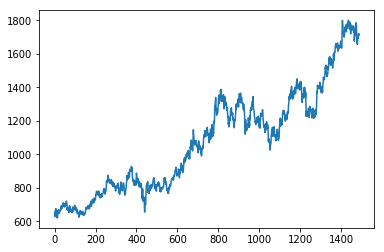

In [4]:
# Loading the dataset
def load_dataset(file_name):
    dataset = read_csv(file_name,index_col=False)
    dataset.columns=['symbol','date','open','high','low','close','volume','name','i_open','i_high','i_low','i_close']
    #print(dataset.head(5))
    dataset.drop(['symbol','date','high','low','volume','name','i_high','i_low'],1,inplace=True)
    dataset.convert_objects(convert_numeric=True)
    return dataset
dataset = load_dataset('500010.txt')
print(dataset.head(5))
pyplot.plot(dataset['open'])
pyplot.show()
 

In [5]:
# preparing for the LSTM

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

vals = 0
for i in glob('*.txt'):
    print(i)
    dataset = load_dataset(i)
    values = dataset.values

    # ensure all data is float
    values = values.astype('float64')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 10, 1) # 3 days of input output of 
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[40,42,43]], axis=1, inplace=True)
    if(type(vals) == int):
        vals = reframed
    else:
        vals = vals.append(reframed)
    #print(vals.shape)
print(vals.head(5))

500010.txt
500124.txt
500180.txt
500182.txt
500209.txt
500312.txt
500510.txt


C:\Users\Admin\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


500520.txt
500696.txt
500820.txt
500875.txt
532174.txt
532187.txt
532215.txt
532454.txt
532500.txt
532555.txt
532921.txt
532977.txt
533278.txt
    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var1(t-9)  var2(t-9)  \
10    0.025506    0.014171    0.042205    0.044905   0.006949   0.018711   
11    0.006949    0.018711    0.023595    0.051109   0.031438   0.031312   
12    0.031438    0.031312    0.061042    0.070509   0.033980   0.040901   
13    0.033980    0.040901    0.057665    0.090092   0.039064   0.036234   
14    0.039064    0.036234    0.075017    0.087855   0.034870   0.046459   

    var3(t-9)  var4(t-9)  var1(t-8)  var2(t-8)    ...     var4(t-3)  \
10   0.023595   0.051109   0.031438   0.031312    ...      0.055959   
11   0.061042   0.070509   0.033980   0.040901    ...      0.037469   
12   0.057665   0.090092   0.039064   0.036234    ...      0.044591   
13   0.075017   0.087855   0.034870   0.046459    ...      0.038050   
14   0.075984   0.091721   0.046691   0.04247

In [6]:
# split into train and test sets
reframed = vals
values = reframed.values
n_train_hours = int(0.8*reframed.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(23664, 40) (23664,) (5916, 40) (5916,)


Train on 23664 samples, validate on 5916 samples
Epoch 1/20
 - 5s - loss: 0.0371 - val_loss: 0.0319
Epoch 2/20
 - 4s - loss: 0.0223 - val_loss: 0.0268
Epoch 3/20
 - 4s - loss: 0.0206 - val_loss: 0.0321
Epoch 4/20
 - 4s - loss: 0.0181 - val_loss: 0.0308
Epoch 5/20
 - 4s - loss: 0.0181 - val_loss: 0.0245
Epoch 6/20
 - 3s - loss: 0.0169 - val_loss: 0.0232
Epoch 7/20
 - 4s - loss: 0.0164 - val_loss: 0.0255
Epoch 8/20
 - 4s - loss: 0.0161 - val_loss: 0.0248
Epoch 9/20
 - 4s - loss: 0.0168 - val_loss: 0.0254
Epoch 10/20
 - 4s - loss: 0.0158 - val_loss: 0.0254
Epoch 11/20
 - 4s - loss: 0.0162 - val_loss: 0.0243
Epoch 12/20
 - 4s - loss: 0.0162 - val_loss: 0.0224
Epoch 13/20
 - 4s - loss: 0.0159 - val_loss: 0.0251
Epoch 14/20
 - 3s - loss: 0.0158 - val_loss: 0.0253
Epoch 15/20
 - 2s - loss: 0.0153 - val_loss: 0.0237
Epoch 16/20
 - 2s - loss: 0.0156 - val_loss: 0.0225
Epoch 17/20
 - 2s - loss: 0.0156 - val_loss: 0.0218
Epoch 18/20
 - 2s - loss: 0.0157 - val_loss: 0.0238
Epoch 19/20
 - 2s - loss

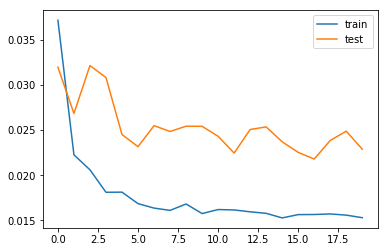

In [7]:
# design network
model = Sequential()
model.add(Dense(40, input_shape=(40,), kernel_initializer='normal', activation='relu'))
#model.add(LSTM(3, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(20,kernel_initializer='normal', activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

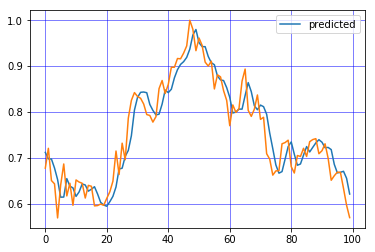

In [8]:
pyplot.grid(color='b', linestyle='-', linewidth=0.5)
pyplot.plot(model.predict(test_X[:100]))
pyplot.legend(['predicted'])
pyplot.plot(test_y[:100])
pyplot.show()
